# Comparison of base GRNs between timepoints

- Last updated: 10/31/2023
- Author: Yang-Joon Kim

- Background: We're acquiring single-cell multiome datasets during the early zebrafish development (0 budstage, 5, 10, 15, 20, and 30 somites stages, total of 6 timepoints).

- Background 2: Compared to the CisBP (promoter database)-derived base GRN + Zebrahub (scRNA-seq) GRNs, our new datasets can potentially reveal some distal regulatory elements, as well as transiently active distal enhancers (via time-resolved scATAC-seq).

- Goal: Here, we will compare the base GRNs (especially the distal regulatory elements for each gene) between timepoints.



In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


import os, sys, shutil, importlib, glob
from tqdm.notebook import tqdm

In [3]:
from celloracle import motif_analysis as ma
import celloracle as co
co.__version__

/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/yang-joon.kim/.conda/envs/celloracle_env/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str

'0.14.0'

In [16]:
# %config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib as mpl

plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams["savefig.dpi"] = 600
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# suppress warning messages regarding the pdf saving
import logging
logging.getLogger('fontTools').setLevel(logging.ERROR)

In [17]:
figpath = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/CCAN_comparison_timepoints/"

## Notes

- 1) We normally process the peaks and CCAN files (from cicero) to map the peaks to TSS, and then filter for the peaks that are highly co-accessible to TSS peaks . This is done in .../02_GRN/01_scATAC-seq_data_processing/02_preprocess_peak_data.ipynb notebook.

- 2) Here, we will just grab the output file (03_data_id_processed_peak_file_danRer11.csv), which has the format of two columns: peaks | mapped genes).

- 3) then, we will compare these across different timepoints, to filter the peaks that are unique in one timepoint, etc.

# Step 1. Import the mapped_TSS/genes dataframes (at different timepoints)

In [14]:
# import the TSS-mapped (linked) peaks
mapped_peaks_15somites = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_cicero_output/03_TDR118_processed_peak_file_danRer11.csv", index_col=0)
mapped_peaks_15somites_rep2 = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/03_TDR119_processed_peak_file_danRer11.csv", index_col=0)

mapped_peaks_20somites = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR125_cicero_output/03_TDR125_processed_peak_file_danRer11.csv", index_col=0)

mapped_peaks_30somites = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR124_cicero_output/03_TDR124_processed_peak_file_danRer11.csv", index_col=0)

In [15]:
print("the number of cis-regulatory elements in 15 somites:", len(mapped_peaks_15somites))
print("the number of cis-regulatory elements in 15 somites (rep2):", len(mapped_peaks_15somites_rep2))
print("the number of cis-regulatory elements in 20 somites:", len(mapped_peaks_20somites))
print("the number of cis-regulatory elements in 30 somites:", len(mapped_peaks_30somites))

the number of cis-regulatory elements in 15 somites: 14511
the number of cis-regulatory elements in 15 somites (rep2): 14478
the number of cis-regulatory elements in 20 somites: 14205
the number of cis-regulatory elements in 30 somites: 13370


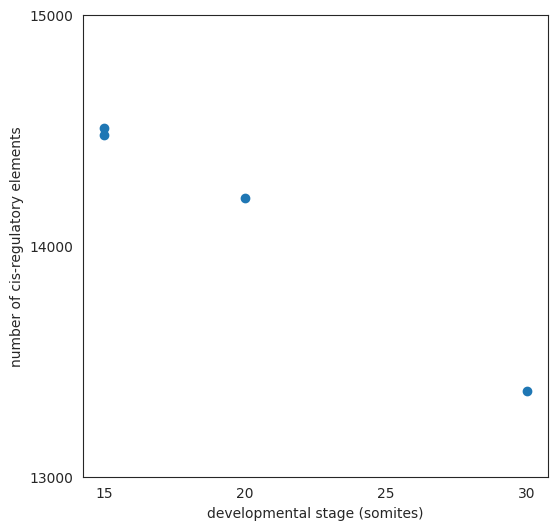

In [20]:
%matplotlib inline
plt.scatter(x=[15, 15, 20, 30], 
            y=[len(mapped_peaks_15somites), len(mapped_peaks_15somites_rep2),
               len(mapped_peaks_20somites), len(mapped_peaks_30somites)])

# Add titles and labels
plt.title('')
plt.xlabel('developmental stage (somites)')
plt.ylabel('number of cis-regulatory elements')
plt.xticks([15, 20, 25, 30])
plt.yticks([13000, 14000, 15000])
plt.ylim([13000, 15000])

plt.savefig(figpath + "num_CCANs_over_time_15_20_30_somites.pdf")
plt.savefig(figpath + "num_CCANs_over_time_15_20_30_somites.png")

plt.show()

## Note:

- There's a trend that the number of active cis-regulatory elements decreasing as the development progresses.
- At the gene level, there are genes whose cis-regulatory elements increases or decreases. We will take a closer look at this in the following sections.

# Step 2. EDA on the dataframes

- **[DONE]1)** number of cis-regulatory elements at each timepoint (if we have more than two timepoints, we can assess the temporal dependence.)

- **[DONE]2)** Overlapping peaks between the two timepoints (venn-diagram?): unique peaks from the peaks1 and peaks2, respetively.

    - 2-1) A pairwise comparison between the CCANs (15 vs 20, 15 vs 30, 15 vs 15 (replicates), 20 vs 30)
    

- **[Advanced]** Among selected peaks (like above), what are the TF motifs that are mapped to those peaks? Do we see any interesting regulatory relationships from those (time-dependent)?

- **[Advanced]** which peaks were detected in which cell-types? This will require us to link back to the Seurat/Signac object.

In [21]:
mapped_peaks_15somites.sort_values("gene_short_name")

,peak_id,gene_short_name
11423,chr5_33214660_33215440,LOC100001344
494,chr11_1088095_1088998,LOC100003140
8431,chr24_27423307_27424172,LOC100141479
3566,chr16_47202794_47203566,LOC100148066
6374,chr20_35247236_35247974,LOC100150082
...,...,...
6849,chr21_23046093_23046882,zw10
9952,chr3_21024761_21025654,zwi
4299,chr18_19455734_19456615,zwilch
6055,chr20_16173312_16174155,zyg11


In [15]:
mapped_peaks_30somites.sort_values("gene_short_name")

,peak_id,gene_short_name
10533,chr5_33214703_33215549,LOC100001344
455,chr11_1088072_1088906,LOC100003140
3238,chr16_47203407_47204218,LOC100148066
5875,chr20_35247224_35247983,LOC100150082
5873,chr20_35245693_35246548,LOC100150082
...,...,...
6328,chr21_23046107_23046904,zw10
9195,chr3_21024514_21025579,zwi
3933,chr18_19455698_19456596,zwilch
5579,chr20_16173304_16174146,zyg11


In [7]:
mapped_peaks_15somites.value_counts("gene_short_name")

gene_short_name
myf5         10
mir196a-1     8
her1          8
tbx16         7
hoxb3a        7
             ..
hspb11        1
hspb15        1
hspb6         1
hspb7         1
zyx           1
Length: 12674, dtype: int64

## 15 somites vs 30 somites - Check some example genes:

- her1 (Segmentation gene)

In [8]:
mapped_peaks_15somites[mapped_peaks_15somites.gene_short_name=="her1"]

,Unnamed: 0,peak_id,gene_short_name
11889,11889,chr5_68794647_68795446,her1
11890,11890,chr5_68795688_68796600,her1
11891,11891,chr5_68797055_68797729,her1
11894,11894,chr5_68797842_68798346,her1
11897,11897,chr5_68803528_68804348,her1
11900,11900,chr5_68808342_68808880,her1
11902,11902,chr5_68809020_68809760,her1
11907,11907,chr5_68887321_68888226,her1


In [9]:
mapped_peaks_30somites[mapped_peaks_30somites.gene_short_name=="her1"]

,Unnamed: 0,peak_id,gene_short_name
10962,10962,chr5_68794672_68795431,her1


In [17]:
mapped_peaks_15somites[mapped_peaks_15somites.gene_short_name=="tbx16"]

,peak_id,gene_short_name
13868,chr8_51528994_51529907,tbx16
13869,chr8_51533600_51534501,tbx16
13872,chr8_51748054_51748950,tbx16
13873,chr8_51753213_51754097,tbx16
13874,chr8_51768267_51769169,tbx16
13875,chr8_51771672_51772555,tbx16
13876,chr8_51773642_51774529,tbx16


In [19]:
mapped_peaks_30somites[mapped_peaks_30somites.gene_short_name=="tbx16"]

,peak_id,gene_short_name
12786,chr8_51753204_51754037,tbx16
12787,chr8_51754460_51755203,tbx16


In [22]:
# functions to extract the coordinates and compute the overlap between the two peaks

def extract_coordinates(peak_id):
    """Extract chromosome, start and end coordinates from peak_id."""
    chrom, start, end = peak_id.split('_')
    return chrom, int(start), int(end)

def has_overlap(peak1, peak2, threshold=10):
    """Check if two peaks have overlap based on a threshold."""
    chrom1, start1, end1 = extract_coordinates(peak1)
    chrom2, start2, end2 = extract_coordinates(peak2)
    
    # Check if they're on the same chromosome
    if chrom1 != chrom2:
        return False
    
    # Check for overlap
    overlap = max(0, min(end1, end2) - max(start1, start2))
    return overlap >= threshold

In [70]:
# To speed things up, we will compare the peaks within the same chromosomes by "group.by" for each chromosome first
df1 = mapped_peaks_15somites
df2 = mapped_peaks_30somites

# Group by chromosome
groups_df1 = df1.groupby(df1['peak_id'].str.split('_').str[0])
groups_df2 = df2.groupby(df2['peak_id'].str.split('_').str[0])

unique_df1_peaks = []
unique_df2_peaks = []

# For each chromosome, compare peaks in df1 with peaks in df2
for chrom in set(groups_df1.groups.keys()).union(groups_df2.groups.keys()):
    peaks_df1 = groups_df1.get_group(chrom) if chrom in groups_df1.groups else pd.DataFrame()
    peaks_df2 = groups_df2.get_group(chrom) if chrom in groups_df2.groups else pd.DataFrame()

    for _, row1 in peaks_df1.iterrows():
        overlapping = any(has_overlap(row1['peak_id'], row2['peak_id']) for _, row2 in peaks_df2.iterrows())
        if not overlapping:
            unique_df1_peaks.append({'peak_id': row1['peak_id'], 'gene_short_name': row1['gene_short_name']})

    for _, row2 in peaks_df2.iterrows():
        overlapping = any(has_overlap(row2['peak_id'], row1['peak_id']) for _, row1 in peaks_df1.iterrows())
        if not overlapping:
            unique_df2_peaks.append({'peak_id': row2['peak_id'], 'gene_short_name': row2['gene_short_name']})

unique_df1 = pd.DataFrame(unique_df1_peaks)
unique_df2 = pd.DataFrame(unique_df2_peaks)

print("Unique peaks in df1:")
print(unique_df1)

print("\nUnique peaks in df2:")
print(unique_df2)



Unique peaks in df1:
                      peak_id gene_short_name
0     chr20_11105433_11106108           flrt2
1         chr20_117983_118832           ypel5
2     chr20_13774061_13774977           opn8c
3     chr20_14869875_14870777       mir199-3a
4     chr20_14875810_14876588       mir199-3a
...                       ...             ...
1722      chr22_724739_725597      zgc:162255
1723    chr22_7461101_7462016         cela1.1
1724    chr22_8005884_8006763         sc:d217
1725    chr22_9472532_9473312       cacna2d2b
1726    chr22_9939440_9940362      zgc:171686

[1727 rows x 2 columns]

Unique peaks in df2:
                     peak_id   gene_short_name
0    chr20_14876787_14877288           mir214a
1    chr20_15091072_15091924  si:dkey-239i20.2
2    chr20_15560098_15560638             caiap
3    chr20_20482879_20483916             six4b
4    chr20_23291417_23292183           slc10a4
..                       ...               ...
586    chr22_5123500_5123999            loxl5a
587 

In [96]:
unique_15_30 = unique_df1
unique_30_15 = unique_df2

In [97]:
# save the unique peaks (dataframe) into csv files
unique_15_30.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_15somites_to_30somites.csv")
unique_30_15.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_30somites_to_15somites.csv")

In [63]:
# save the top 50 genes as a csv file (gene_short_name; number of unique CCANs)
unique_15_30.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_15somites_to_30somites.csv")
unique_30_15.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_30somites_to_15somites.csv")

In [39]:
# Check for some genes
gene_name = "rpz3"
print(mapped_peaks_15somites[mapped_peaks_15somites.gene_short_name==gene_name])
print(mapped_peaks_30somites[mapped_peaks_30somites.gene_short_name==gene_name])

Empty DataFrame
Columns: [peak_id, gene_short_name]
Index: []
                      peak_id gene_short_name
3230  chr16_46459365_46460332            rpz3


In [40]:
# Check for some genes
gene_name = "noto"
print(mapped_peaks_15somites[mapped_peaks_15somites.gene_short_name==gene_name])
print(mapped_peaks_30somites[mapped_peaks_30somites.gene_short_name==gene_name])

                      peak_id gene_short_name
1543  chr13_14975609_14976433            noto
                      peak_id gene_short_name
1406  chr13_14974463_14975210            noto
1407  chr13_14975703_14976519            noto


In [59]:
# Copy the dataframes for future comparisons
unique_15_30 = unique_df1
unique_30_15 = unique_df2

## 15 somites vs 20 somites

In [65]:
# To speed things up, we will compare the peaks within the same chromosomes by "group.by" for each chromosome first
df1 = mapped_peaks_15somites
df2 = mapped_peaks_20somites

# Group by chromosome
groups_df1 = df1.groupby(df1['peak_id'].str.split('_').str[0])
groups_df2 = df2.groupby(df2['peak_id'].str.split('_').str[0])

unique_df1_peaks = []
unique_df2_peaks = []

# For each chromosome, compare peaks in df1 with peaks in df2
for chrom in set(groups_df1.groups.keys()).union(groups_df2.groups.keys()):
    peaks_df1 = groups_df1.get_group(chrom) if chrom in groups_df1.groups else pd.DataFrame()
    peaks_df2 = groups_df2.get_group(chrom) if chrom in groups_df2.groups else pd.DataFrame()

    for _, row1 in peaks_df1.iterrows():
        overlapping = any(has_overlap(row1['peak_id'], row2['peak_id']) for _, row2 in peaks_df2.iterrows())
        if not overlapping:
            unique_df1_peaks.append({'peak_id': row1['peak_id'], 'gene_short_name': row1['gene_short_name']})

    for _, row2 in peaks_df2.iterrows():
        overlapping = any(has_overlap(row2['peak_id'], row1['peak_id']) for _, row1 in peaks_df1.iterrows())
        if not overlapping:
            unique_df2_peaks.append({'peak_id': row2['peak_id'], 'gene_short_name': row2['gene_short_name']})

unique_15_20 = pd.DataFrame(unique_df1_peaks)
unique_20_15 = pd.DataFrame(unique_df2_peaks)

print("Unique peaks in 15 somites (vs 20 somites):")
print(unique_15_20)

print("\nUnique peaks in 20 somites (vs 15 somites):")
print(unique_20_15)

Unique peaks in 15 somites (vs 20 somites):
                     peak_id gene_short_name
0    chr20_11105433_11106108           flrt2
1    chr20_15600154_15601120           faslg
2    chr20_19543851_19544737         mir133b
3    chr20_19543851_19544737        mir206-1
4    chr20_26066940_26067539          myct1a
..                       ...             ...
684    chr22_5019416_5020274             rx1
685    chr22_5025489_5026380             rx1
686    chr22_5299606_5300492          mir27e
687    chr22_5822294_5822973           cers5
688    chr22_8005884_8006763         sc:d217

[689 rows x 2 columns]

Unique peaks in 20 somites (vs 15 somites):
                     peak_id  gene_short_name
0    chr20_13660315_13661103           tagapb
1    chr20_14876772_14877282          mir214a
2    chr20_15015634_15016146             myoc
3    chr20_20325637_20326472          snapc1a
4    chr20_21806500_21807283           syne2a
..                       ...              ...
393    chr22_5324192_5324

In [66]:
unique_15_20 = pd.DataFrame(unique_df1_peaks)
unique_20_15 = pd.DataFrame(unique_df2_peaks)

In [67]:
print(unique_15_20.value_counts("gene_short_name").head(20))

print(unique_20_15.value_counts("gene_short_name").head(20))

gene_short_name
myf5         7
mir196a-1    6
her1         6
hoxb3a       4
her7         4
tbx16        4
cyp26a1      4
mir196b      4
hoxc3a       3
hoxc6a       3
fezf2        3
usp54a       3
ncam1a       3
mir196a-2    3
tbx6         3
mir196d      3
msgn1        3
sox10        2
ecrg4a       2
elavl3       2
dtype: int64
gene_short_name
myog                 4
pigr                 2
hbbe3                2
cacna1sa             2
bricd5               2
stab1                2
LOC100150619         1
si:ch211-202h22.8    1
si:ch211-184m13.4    1
si:ch211-15e22.3     1
si:ch211-125e6.12    1
si:ch211-122l24.6    1
si:ch211-121a2.2     1
sfxn3                1
serpinb1l2           1
serpina10a           1
si:ch211-240l19.6    1
serac1               1
sept9b               1
selenoh              1
dtype: int64


In [68]:
# save the unique peaks (dataframe) into csv files
unique_15_20.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_15somites_to_20somites.csv")
unique_15_20.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_20somites_to_15somites.csv")

In [63]:
# save the top 50 genes as a csv file (gene_short_name; number of unique CCANs)
unique_15_20.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_15somites_to_20somites.csv")
unique_20_15.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_20somites_to_15somites.csv")

## 20 somites vs 30 somites



In [75]:
# To speed things up, we will compare the peaks within the same chromosomes by "group.by" for each chromosome first
df1 = mapped_peaks_20somites
df2 = mapped_peaks_30somites

# Group by chromosome
groups_df1 = df1.groupby(df1['peak_id'].str.split('_').str[0])
groups_df2 = df2.groupby(df2['peak_id'].str.split('_').str[0])

unique_df1_peaks = []
unique_df2_peaks = []

# For each chromosome, compare peaks in df1 with peaks in df2
for chrom in set(groups_df1.groups.keys()).union(groups_df2.groups.keys()):
    peaks_df1 = groups_df1.get_group(chrom) if chrom in groups_df1.groups else pd.DataFrame()
    peaks_df2 = groups_df2.get_group(chrom) if chrom in groups_df2.groups else pd.DataFrame()

    for _, row1 in peaks_df1.iterrows():
        overlapping = any(has_overlap(row1['peak_id'], row2['peak_id']) for _, row2 in peaks_df2.iterrows())
        if not overlapping:
            unique_df1_peaks.append({'peak_id': row1['peak_id'], 'gene_short_name': row1['gene_short_name']})

    for _, row2 in peaks_df2.iterrows():
        overlapping = any(has_overlap(row2['peak_id'], row1['peak_id']) for _, row1 in peaks_df1.iterrows())
        if not overlapping:
            unique_df2_peaks.append({'peak_id': row2['peak_id'], 'gene_short_name': row2['gene_short_name']})

unique_20_30 = pd.DataFrame(unique_df1_peaks)
unique_30_20 = pd.DataFrame(unique_df2_peaks)

print("Unique peaks in df1:")
print(unique_20_30.value_counts("gene_short_name").head(20))

print("\nUnique peaks in df2:")
print(unique_30_20.value_counts("gene_short_name").head(20))

In [74]:
# save the unique peaks (dataframe) into csv files
unique_20_30.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_20somites_to_30somites.csv")
unique_30_20.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_30somites_to_20somites.csv")

In [68]:
# save the top 50 genes as a csv file (gene_short_name; number of unique CCANs)
unique_20_30.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_20somites_to_30somites.csv")
unique_30_20.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_30somites_to_20somites.csv")

## 15 somites vs 15 somites (biological replicates)

- This will be our negative control for the cis-regulatory elements.
- In theory, there should be no meaningful differences between the biological replicates (CCANs)

In [77]:
# To speed things up, we will compare the peaks within the same chromosomes by "group.by" for each chromosome first
df1 = mapped_peaks_15somites
df2 = mapped_peaks_15somites_rep2

# Group by chromosome
groups_df1 = df1.groupby(df1['peak_id'].str.split('_').str[0])
groups_df2 = df2.groupby(df2['peak_id'].str.split('_').str[0])

unique_df1_peaks = []
unique_df2_peaks = []

# For each chromosome, compare peaks in df1 with peaks in df2
for chrom in set(groups_df1.groups.keys()).union(groups_df2.groups.keys()):
    peaks_df1 = groups_df1.get_group(chrom) if chrom in groups_df1.groups else pd.DataFrame()
    peaks_df2 = groups_df2.get_group(chrom) if chrom in groups_df2.groups else pd.DataFrame()

    for _, row1 in peaks_df1.iterrows():
        overlapping = any(has_overlap(row1['peak_id'], row2['peak_id']) for _, row2 in peaks_df2.iterrows())
        if not overlapping:
            unique_df1_peaks.append({'peak_id': row1['peak_id'], 'gene_short_name': row1['gene_short_name']})

    for _, row2 in peaks_df2.iterrows():
        overlapping = any(has_overlap(row2['peak_id'], row1['peak_id']) for _, row1 in peaks_df1.iterrows())
        if not overlapping:
            unique_df2_peaks.append({'peak_id': row2['peak_id'], 'gene_short_name': row2['gene_short_name']})

unique_15_15_rep1 = pd.DataFrame(unique_df1_peaks)
unique_15_15_rep2 = pd.DataFrame(unique_df2_peaks)

print("Unique peaks in df1:")
print(unique_15_15_rep1.value_counts("gene_short_name").head(20))

print("\nUnique peaks in df2:")
print(unique_15_15_rep2.value_counts("gene_short_name").head(20))

Unique peaks in df1:
gene_short_name
ripply2       2
ncam1a        2
pcdh8         2
cldni         1
myf5          1
pak2a         1
pitpnc1b      1
rargb         1
rx2           1
cnksr1        1
snai1a        1
sox21b        1
stra6         1
vax1          1
vgll4l        1
zgc:136538    1
mir219-1      1
mir196d       1
mir196a-2     1
mir124-5      1
dtype: int64

Unique peaks in df2:
gene_short_name
pou3f3a    3
coro7      1
foxc1a     1
mllt3      1
sox10      1
sox19a     1
vwde       1
dtype: int64


In [73]:
print(len(unique_15_15_rep1))
print(len(unique_15_15_rep2))

37
9


In [78]:
# save the unique peaks (dataframe) into csv files
unique_15_15_rep1.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_15somites_to_15somites_rep1.csv")
unique_15_15_rep2.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_15somites_to_15somites_rep2.csv")

In [70]:
# save the top 50 genes as a csv file (gene_short_name; number of unique CCANs)
unique_15_15_rep1.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_15somites_to_15somites_rep1.csv")
unique_15_15_rep2.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_15somites_to_15somites_rep2.csv")

# Checkpoint (This is where we can restart the notebook after loading the libraries)

In [98]:
# Load all csv files (if we resume from here)
unique_15_20 = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_15somites_to_20somites.csv", index_col=0)
unique_20_15 = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_20somites_to_15somites.csv", index_col=0)
unique_15_30 = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_15somites_to_30somites.csv", index_col=0)
unique_30_15 = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_30somites_to_15somites.csv", index_col=0)
unique_20_30 = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_20somites_to_30somites.csv", index_col=0)
unique_30_20 = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_30somites_to_20somites.csv", index_col=0)
unique_15_15_rep1 = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_15somites_to_15somites_rep1.csv", index_col=0)
unique_15_15_rep2 = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_15somites_to_15somites_rep2.csv", index_col=0)


In [99]:
unique_15_30

,peak_id,gene_short_name
0,chr20_11105433_11106108,flrt2
1,chr20_117983_118832,ypel5
2,chr20_13774061_13774977,opn8c
3,chr20_14869875_14870777,mir199-3a
4,chr20_14875810_14876588,mir199-3a
...,...,...
1722,chr22_724739_725597,zgc:162255
1723,chr22_7461101_7462016,cela1.1
1724,chr22_8005884_8006763,sc:d217
1725,chr22_9472532_9473312,cacna2d2b


## visualization 

We want to visualize the above results in different ways.

- 1) a rank plot showing the genes (y-axis), and the number of cis-regulatory elements (x-axis): For all combinations

- 2) linkage plot showing the active regulatory elements for the top genes, at different timepoints (show the increase/decrease of cis-regulatory elements).

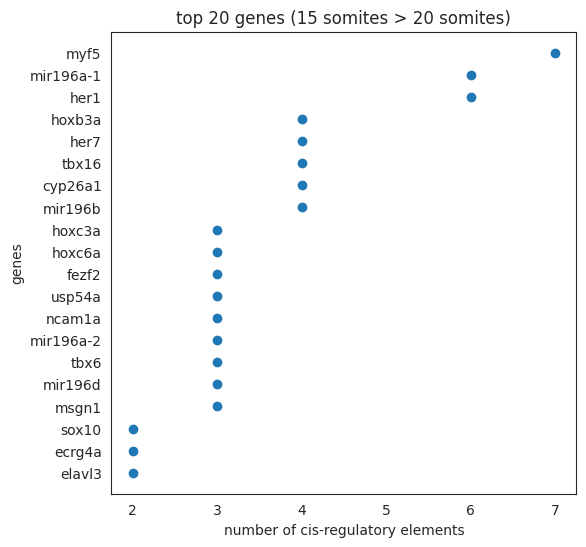

In [89]:
# 15somites > 20somites
top_genes = unique_15_20.value_counts("gene_short_name").head(20)

# Extract gene names and their counts
gene_names = top_genes.index.tolist()
counts = top_genes.values

# Create rank plot
plt.figure(figsize=(6,6))  # Adjust the figure size
plt.scatter(counts, gene_names)

# Add titles and labels
# plt.title('Top 20 Genes Rank Plot')
plt.title("top 20 genes (15 somites > 20 somites)")
plt.xlabel('number of cis-regulatory elements')
plt.ylabel('genes')
#plt.grid(axis='x')  # Add a grid on the x-axis for better readability
# Invert the y-axis order
plt.gca().invert_yaxis()

# save the figure
# plt.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/CCAN_comparison_timepoints/rank_top20genes_15vs20.png")
# plt.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/CCAN_comparison_timepoints/rank_top20genes_15vs20.pdf")

# Display the plot
plt.show()

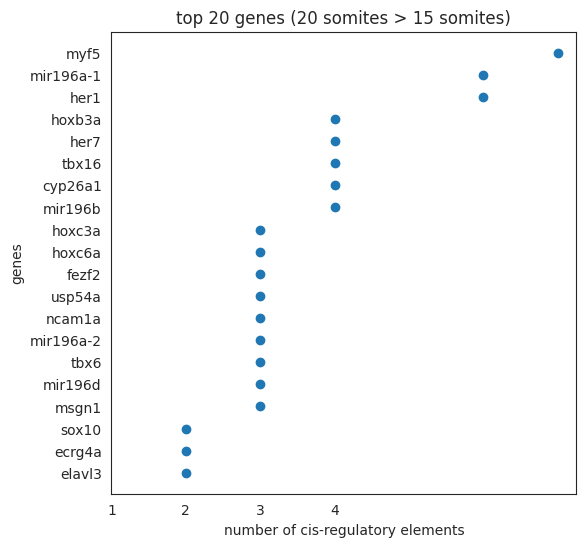

In [90]:
# 20somites > 15somites
top_genes = unique_20_15.value_counts("gene_short_name").head(20)

# Extract gene names and their counts
gene_names = top_genes.index.tolist()
counts = top_genes.values

# Create rank plot
plt.figure(figsize=(6,6))  # Adjust the figure size
plt.scatter(counts, gene_names)

# Add titles and labels
# plt.title('Top 20 Genes Rank Plot')
plt.title("top 20 genes (20 somites > 15 somites)")
plt.xlabel('number of cis-regulatory elements')
plt.xticks([1, 2, 3, 4])
plt.ylabel('genes')
#plt.grid(axis='x')  # Add a grid on the x-axis for better readability
# Invert the y-axis order
plt.gca().invert_yaxis()

# save the figure
# plt.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/CCAN_comparison_timepoints/rank_top20genes_20vs15.png")
# plt.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/CCAN_comparison_timepoints/rank_top20genes_20vs15.pdf")

# Display the plot
plt.show()

We can repeat this for all pairs for the comparison.

Note that we might want to make one for 15 somites stage, between two biological replicates.

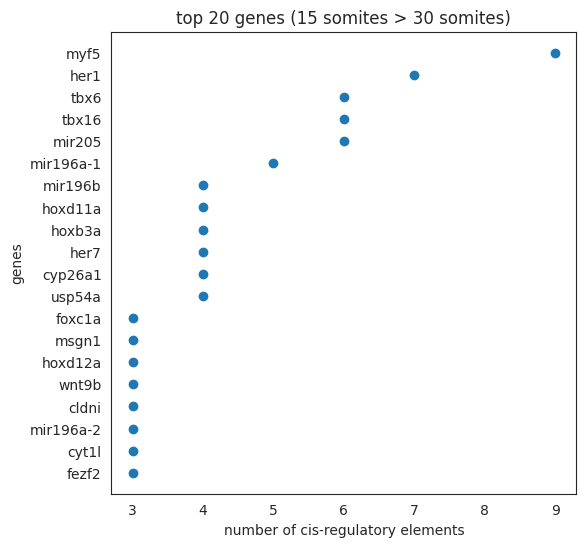

In [100]:
# 15somites > 30somites
top_genes = unique_15_30.value_counts("gene_short_name").head(20)

# Extract gene names and their counts
gene_names = top_genes.index.tolist()
counts = top_genes.values

# Create rank plot
plt.figure(figsize=(6,6))  # Adjust the figure size
plt.scatter(counts, gene_names)

# Add titles and labels
# plt.title('Top 20 Genes Rank Plot')
plt.title("top 20 genes (15 somites > 30 somites)")
plt.xlabel('number of cis-regulatory elements')
plt.ylabel('genes')
#plt.grid(axis='x')  # Add a grid on the x-axis for better readability
# Invert the y-axis order
plt.gca().invert_yaxis()

# save the figure
plt.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/CCAN_comparison_timepoints/rank_top20genes_15vs30.png")
plt.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/CCAN_comparison_timepoints/rank_top20genes_15vs30.pdf")

# Display the plot
plt.show()

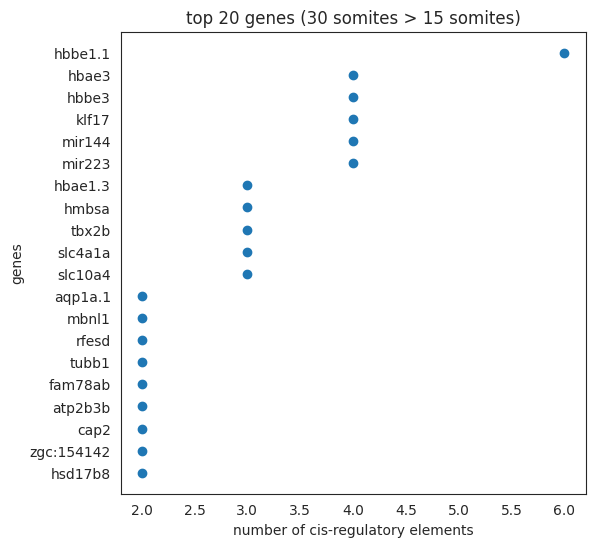

In [102]:
# 30somites > 15somites
top_genes = unique_30_15.value_counts("gene_short_name").head(20)

# Extract gene names and their counts
gene_names = top_genes.index.tolist()
counts = top_genes.values

# Create rank plot
plt.figure(figsize=(6,6))  # Adjust the figure size
plt.scatter(counts, gene_names)

# Add titles and labels
# plt.title('Top 20 Genes Rank Plot')
plt.title("top 20 genes (30 somites > 15 somites)")
plt.xlabel('number of cis-regulatory elements')
plt.ylabel('genes')
#plt.grid(axis='x')  # Add a grid on the x-axis for better readability
# Invert the y-axis order
plt.gca().invert_yaxis()

# save the figure
plt.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/CCAN_comparison_timepoints/rank_top20genes_30vs15.png")
plt.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/CCAN_comparison_timepoints/rank_top20genes_30vs15.pdf")

# Display the plot
plt.show()

## Step 2-2. Visualization of the genomic regions and CCANs

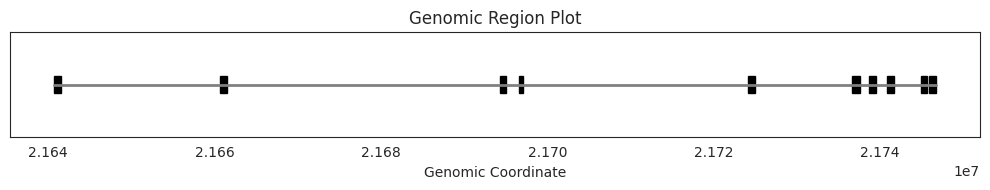

In [156]:
# visualize the genomic regions with a linear plot
import matplotlib.patches as patches

# define the gene name
gene_name = "myf5"
df = mapped_peaks_15somites[mapped_peaks_15somites.gene_short_name==gene_name]

# Parsing peak_id to get start and end coordinates
df['start'] = df['peak_id'].str.split('_').str[1].astype(int)
df['end'] = df['peak_id'].str.split('_').str[2].astype(int)

# Plotting
fig, ax = plt.subplots(figsize=(10, 2))

# Plotting a thin line for the genomic region
ax.plot([df['start'].min(), df['end'].max()], [1, 1], color='grey', linewidth=2)

# Adjusting the height and position of the boxes
box_height = 0.1
box_position = 1 - box_height / 2

# Plotting black boxes for each peak using rectangles
for _, row in df.iterrows():
    rect = patches.Rectangle((row['start'], box_position), row['end'] - row['start'], box_height, linewidth=1, edgecolor='black', facecolor='black')
    ax.add_patch(rect)

# Setting y-axis limits and removing y-axis ticks
ax.set_ylim(0.7, 1.3)
ax.set_yticks([])
ax.set_xlabel('Genomic Coordinate')
ax.set_title('Genomic Region Plot')

plt.tight_layout()
plt.show()

In [ ]:
# visualize the genomic regions with a linear plot
import matplotlib.patches as patches

# define the gene name
gene_name = "myf5"
df = mapped_peaks_15somites[mapped_peaks_15somites.gene_short_name==gene_name]

# Parsing peak_id to get start and end coordinates
df['start'] = df['peak_id'].str.split('_').str[1].astype(int)
df['end'] = df['peak_id'].str.split('_').str[2].astype(int)

# Plotting
fig, ax = plt.subplots(figsize=(10, 2))

# Plotting a thin line for the genomic region
ax.plot([df['start'].min(), df['end'].max()], [1, 1], color='grey', linewidth=2)

# Adjusting the height and position of the boxes
box_height = 0.1
box_position = 1 - box_height / 2

# Plotting black boxes for each peak using rectangles
for _, row in df.iterrows():
    rect = patches.Rectangle((row['start'], box_position), row['end'] - row['start'], box_height, linewidth=1, edgecolor='black', facecolor='black')
    ax.add_patch(rect)

# Setting y-axis limits and removing y-axis ticks
ax.set_ylim(0.7, 1.3)
ax.set_yticks([])
ax.set_xlabel('Genomic Coordinate')
ax.set_title('Genomic Region Plot')

plt.tight_layout()
plt.show()

In [111]:
# a function to plot the genomic regions
import matplotlib.patches as patches

def compute_start_end(df):
    """Function to compute start and end coordinates for a dataframe."""
    df['start'] = df['peak_id'].str.split('_').str[1].astype(int)
    df['end'] = df['peak_id'].str.split('_').str[2].astype(int)
    return df

# plot_peaks with y_base as an input argument to stagger different plots on top of each other (along the y-axis)
def plot_peaks(df, ax, y_base, color, label=None):
    """Function to plot peaks at a specified y-axis basis."""
    for _, row in df.iterrows():
        rect = patches.Rectangle((row['start'], y_base), row['end'] - row['start'], 0.1, linewidth=1, edgecolor=color, facecolor=color, label=label)
        ax.add_patch(rect)
        label = None  # Set to None to prevent repeating the label
        

def plot_peaks_with_alpha(df, ax, color, label=None):
    """Function to plot peaks with alpha for overlapping peaks."""
    for i, (_, row) in enumerate(df.iterrows()):
        # Only add label for the first rectangle of each group
        lbl = label if i == 0 else None
        rect = patches.Rectangle((row['start'], 0.9), row['end'] - row['start'], 0.2, linewidth=1, edgecolor=color, facecolor=color, alpha=0.5, label=lbl)
        ax.add_patch(rect)

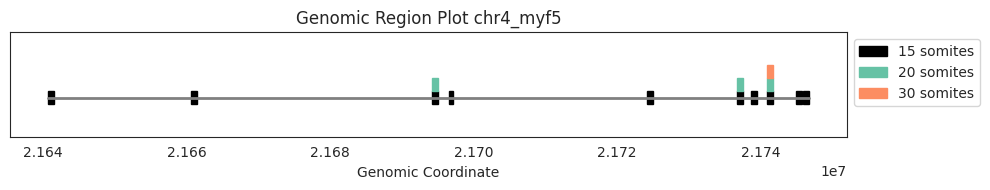

In [195]:
# Setting up color options
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
seaborn_set2 = sns.color_palette("Set2")

# Define the gene name
gene_name = "myf5"

# Define the dataframes
# 15 somites
df1 = mapped_peaks_15somites[mapped_peaks_15somites.gene_short_name == gene_name]
# 20 somites
df2 = mapped_peaks_20somites[mapped_peaks_20somites.gene_short_name == gene_name]
# 30 somites
df3 = mapped_peaks_30somites[mapped_peaks_30somites.gene_short_name == gene_name]

# Compute the start and end positions of the peaks
df1 = compute_start_end(df1)
df2 = compute_start_end(df2)
df3 = compute_start_end(df3)

# Extracting chromosome number
chromosome = df1['peak_id'].iloc[0].split('_')[0]

# Plotting
fig, ax = plt.subplots(figsize=(10, 2))

# Plotting a thin line for the genomic region
genomic_start = min(df1['start'].min(), df2['start'].min(), df3['start'].min())
genomic_end = max(df1['end'].max(), df2['end'].max(), df3['end'].max())
ax.plot([genomic_start, genomic_end], [1, 1], color='grey', linewidth=2)

# Plot peaks from df1 in black at y_base=1
plot_peaks(df1, ax, 0.95, 'black', "15 somites")

# Plot peaks from df2 in a different color, e.g., 'blue' at y_base=1.1
plot_peaks(df2, ax, 1.05, seaborn_set2[0], "20 somites")

# Plot peaks from df3 at y_base=1.3
plot_peaks(df3, ax, 1.15, seaborn_set2[1], "30 somites")

# Setting y-axis limits and removing y-axis ticks
ax.set_ylim(0.7, 1.5)
ax.set_yticks([])
ax.set_xlabel('Genomic Coordinate')
ax.set_title('Genomic Region Plot ' + chromosome + "_" + gene_name)
# Adjust the legend position and size
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 10})

plt.tight_layout()

plt.savefig(figpath + "coverage_plot_CCANs_" + gene_name + ".png")
plt.savefig(figpath + "coverage_plot_CCANs_" + gene_name + ".pdf")

plt.show()

In [115]:
# Define the timepoints
timepoints = ["0budstage", "5somites", "10somites", "15somites", "20somites", "30somites"]

# Load the "viridis" colormap
viridis = plt.cm.get_cmap('viridis', 256)

# Select a subset of the colormap to ensure that "30 somites" is yellow
# You can adjust the start and stop indices to shift the colors
start = 50
stop = 256
colors = viridis(np.linspace(start/256, stop/256, len(timepoints)))

# Create a dictionary to map timepoints to colors
color_dict = dict(zip(timepoints, colors))
color_dict

{'0budstage': array([0.255645, 0.260703, 0.528312, 1.      ]),
 '5somites': array([0.180629, 0.429975, 0.557282, 1.      ]),
 '10somites': array([0.123463, 0.581687, 0.547445, 1.      ]),
 '15somites': array([0.226397, 0.728888, 0.462789, 1.      ]),
 '20somites': array([0.575563, 0.844566, 0.256415, 1.      ]),
 '30somites': array([0.993248, 0.906157, 0.143936, 1.      ])}

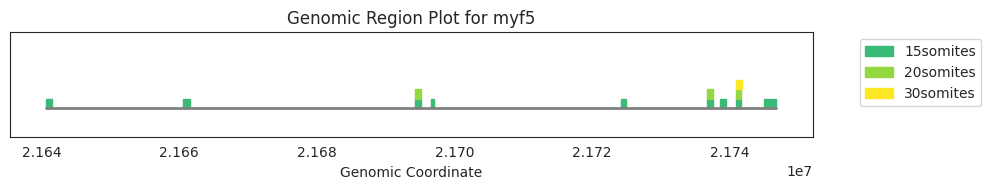

In [129]:
# Let's make the above as a function
# inputs: (1) gene_name, (2) a set of dataframes (at each timepoint)
# optional arguments (1) figpath, (2)
# workflow:
# output: a plot to save


# colormap
# Define the timepoints
timepoints = ["0budstage", "5somites", "10somites", "15somites", "20somites", "30somites"]

# Load the "viridis" colormap
viridis = plt.cm.get_cmap('viridis', 256)

# Select a subset of the colormap to ensure that "30 somites" is yellow
# You can adjust the start and stop indices to shift the colors
start = 50
stop = 256
colors = viridis(np.linspace(start/256, stop/256, len(timepoints)))

# Create a dictionary to map timepoints to colors
color_dict = dict(zip(timepoints, colors))
color_dict

# Define the gene name
gene_name = "myf5"

def plot_CCANs_genomic_loci(CCANs, timepoints, gene_name, colordict, 
                            save_fig=False, figpath = None):
    """
    Description: 
    This function takes a list of CCANs (dataframes for each timepoint), 
    plots the genomic region with CCANs for each timepoint for "gene_name".
    
    Parameters:
    1) gene_name: Name of the gene, i.e. "myf5", "her1"
    2) CCANs: A list of dataframes (one dataframe for each timepoint), i.e. [df1, df2, df3]
    3) timepoints: A list of timepoint labels corresponding to each dataframe in CCANs
    4) colordict: A dictionary of {timepoints:colors (viridis)}
    """
    
    if len(CCANs) != len(timepoints):
        raise ValueError("The number of CCANs dataframes and timepoints labels must be equal")

    # colormap - just define at the beginning (this can be replaced)
    # Define the timepoints
    all_timepoints = ["0budstage", "5somites", "10somites", "15somites", "20somites", "30somites"]

    # Load the "viridis" colormap
    viridis = plt.cm.get_cmap('viridis', 256)

    # Select a subset of the colormap to ensure that "30 somites" is yellow
    # You can adjust the start and stop indices to shift the colors
    start = 50
    stop = 256
    colors = viridis(np.linspace(start/256, stop/256, len(all_timepoints)))

    # Create a dictionary to map timepoints to colors
    color_dict = dict(zip(all_timepoints, colors))
    color_dict
    
    # generate a figure object    
    fig, ax = plt.subplots(figsize=(10, 2))
    
    genomic_start, genomic_end = float('inf'), 0

    for index, (df, stage) in enumerate(zip(CCANs, timepoints)):
        df = df[df.gene_short_name == gene_name]
        df = compute_start_end(df)
        
        genomic_start = min(genomic_start, df['start'].min())
        genomic_end = max(genomic_end, df['end'].max())
        
        plot_peaks(df, ax, 1 + index*0.1, colordict[stage], stage)
    
    ax.plot([genomic_start, genomic_end], [1, 1], color='grey', linewidth=2)
    
    ax.set_ylim(0.7, 1 + len(CCANs)*0.1 + 0.5)
    ax.set_yticks([])
    ax.set_xlabel('Genomic Coordinate')
    ax.set_title(f'Genomic Region Plot for {gene_name}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    if save_fig==True:
        plt.savefig(figpath + "coverage_plot_CCANs_" + gene_name + ".png")
        plt.savefig(figpath + "coverage_plot_CCANs_" + gene_name + ".pdf")
    
    plt.show()
        
        
plot_CCANs_genomic_loci([mapped_peaks_15somites, mapped_peaks_20somites, mapped_peaks_30somites],
                        gene_name="myf5", timepoints=["15somites", "20somites","30somites"], colordict=color_dict)
    


## Additional steps:

- map out the TSS (from CellOracle's TSS database - from CisBP?)



# Step 3. Comparison of base GRNs

- [To-Do] Move this section (and forward) to another notebook (to keep things modular)

- Now, we want to compare the regulatory TFs for each gene (cis-regulatory element), especially for genes which have different cis-regulatory profiles over time. Check for the genes that have varying cis-regulatory elements, whether they exist in our base GRN (as targets, or reg.TFs). Genes without TSS annotation will be missing in our base GRN.

- 1) We will import the base GRN (which is a dataframe of peaks-by-TFs) for each timeframe.
- 2) Pick top 10-20 (or 50) genes whose cis-regulatory elements change significantly over time (from the Step 2.)
- 3) Map out the TFs that are differentially activating/repressing those genes at the base GRN level (for the top 10-50 genes)

- Let's start with "myf5" gene, whose cis-regulatory elements increases over time.

In [199]:
# Check the peaks that were in 15 somites but not in 20 somites (or 30 somites)
# Let's use "myf5" gene as an example
unique_15_20[unique_15_20.gene_short_name=="myf5"]

,peak_id,gene_short_name
116,chr4_21640698_21641565,myf5
117,chr4_21660593_21661497,myf5
118,chr4_21696596_21697063,myf5
119,chr4_21724146_21724976,myf5
120,chr4_21738624_21739481,myf5
121,chr4_21744914_21745703,myf5
122,chr4_21745860_21746718,myf5


In [55]:
baseGRN_15somites = pd.read_parquet("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_cicero_output/05_TDR118_base_GRN_dataframe.parquet")
baseGRN_15somites

,peak_id,gene_short_name,A6H8I1_DANRE,CABZ01017151.1,CABZ01056727.1,CABZ01057488.2,CABZ01066696.1,CABZ01067175.1,CABZ01079847.1,CABZ01081359.1,...,znf143b,znf148,znf281a,znf281b,znf652,znf653,znf711,znf740b,znf76,zzz3
0,chr10_10310135_10311044,mir219-1,0,0,1,0,0,1,0,0,...,0,1,1,1,0,0,0,0,0,0
1,chr10_10312654_10313520,urm1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,chr10_10318857_10319768,mir219-1,0,0,1,1,0,1,0,0,...,0,1,1,1,0,0,0,0,0,0
3,chr10_10330150_10331040,mir219-1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,chr10_10728430_10729439,swi5,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14506,chr9_9670995_9671898,gsk3ba,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
14507,chr9_9841650_9842440,fstl1b,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14508,chr9_9960217_9961167,prmt2,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14509,chr9_9977190_9977958,ugt1a1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
baseGRN_cisbp = co.data.load_zebrafish_promoter_base_GRN()
baseGRN_cisbp

Loading prebuilt promoter base-GRN. Version: danRer11_CisBPv2_fpr2


,peak_id,gene_short_name,A6H8I1_DANRE,CABZ01017151.1,CABZ01056727.1,CABZ01057488.2,CABZ01066696.1,CABZ01067175.1,CABZ01079847.1,CABZ01081359.1,...,znf143b,znf148,znf281a,znf281b,znf652,znf653,znf711,znf740b,znf76,zzz3
0,chr10_10312024_10313124,urm1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_10329454_10330554,mir219-1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,chr10_10385573_10386673,sardh,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chr10_10607018_10608118,dbh,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_10727977_10729077,swi5,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17775,chrUn_KZ116019v1_8579_9679,klc2,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
17776,chrUn_KZ116023v1_2574_3674,zgc:153137,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
17777,chrUn_KZ116034v1_31715_32815,cd247,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17778,chrUn_KZ116034v1_9585_9601,pou2f1a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
baseGRN_cisbp[baseGRN_cisbp.gene_short_name=="myf5"]

,peak_id,gene_short_name,A6H8I1_DANRE,CABZ01017151.1,CABZ01056727.1,CABZ01057488.2,CABZ01066696.1,CABZ01067175.1,CABZ01079847.1,CABZ01081359.1,...,znf143b,znf148,znf281a,znf281b,znf652,znf653,znf711,znf740b,znf76,zzz3
12874,chr4_21740228_21740757,myf5,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12875,chr4_21740758_21741858,myf5,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
baseGRN_15somites[baseGRN_15somites.gene_short_name=="myf5"]

,peak_id,gene_short_name,A6H8I1_DANRE,CABZ01017151.1,CABZ01056727.1,CABZ01057488.2,CABZ01066696.1,CABZ01067175.1,CABZ01079847.1,CABZ01081359.1,...,znf143b,znf148,znf281a,znf281b,znf652,znf653,znf711,znf740b,znf76,zzz3
10758,chr4_21640698_21641565,myf5,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10761,chr4_21660593_21661497,myf5,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
10762,chr4_21694264_21695059,myf5,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10763,chr4_21696596_21697063,myf5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10764,chr4_21724146_21724976,myf5,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10765,chr4_21736676_21737587,myf5,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10766,chr4_21738624_21739481,myf5,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10767,chr4_21740822_21741654,myf5,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10768,chr4_21744914_21745703,myf5,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10769,chr4_21745860_21746718,myf5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
unique_15_20[unique_15_20.gene_short_name=="myf5"]

,peak_id,gene_short_name
116,chr4_21640698_21641565,myf5
117,chr4_21660593_21661497,myf5
118,chr4_21696596_21697063,myf5
119,chr4_21724146_21724976,myf5
120,chr4_21738624_21739481,myf5
121,chr4_21744914_21745703,myf5
122,chr4_21745860_21746718,myf5


In [59]:
# example gene: 'myf5'
gene_name = "myf5"

# define a dict to save the peaks-regulatory TFs as pairs
genes_for_peak = {}

# Filter dataframe for peaks with gene_short_name as 'myf5'
filtered_df = baseGRN_15somites[baseGRN_15somites['gene_short_name'] == gene_name]

# Drop the 'gene_short_name' column as it's no longer needed for the extraction
filtered_df = filtered_df.drop(columns=['gene_short_name'])

# Extract genes with "1" for each peak
genes_for_peak = {}
for peak, row in filtered_df.iterrows():
    genes_for_peak[row.peak_id] = row.index[row == 1].tolist()

# print(genes_for_peak)


In [103]:
# example gene: 'myf5'
gene_name = "myf5"

# uniquely accessible peaks(CCANs) for the specific "gene_name"
unique_15_20_peaks = unique_15_20[unique_15_20.gene_short_name==gene_name].peak_id.to_list()
unique_15_20_peaks

shared_peaks = [peak for peak in genes_for_peak.keys() if peak not in unique_15_20_peaks]
shared_peaks

# compute the regulatory TFs from the base GRN for each peak group (unique vs shared)
regTFs_from_peaks_unique_15_20 = set(gene for peak_id in unique_15_20_peaks for gene in genes_for_peak[peak_id])

regTFs_from_peaks_shared_15_20 = set(gene for peak_id in shared_peaks for gene in genes_for_peak[peak_id])


In [104]:
# the number of unique and shared regulatory TFs between 15 somites and 20 somites (unique in 15 compared to 20 somites)
print(len(regTFs_from_peaks_unique_15_20))
print(len(regTFs_from_peaks_shared_15_20))

625
471


In [105]:
# Now, let's take a look at the regulatory TFs that are only present in "unique" peak groups (TFs that are not present in the shared peaks)
unique_regTFs_15_20 = set(regTFs_from_peaks_unique_15_20) - set(regTFs_from_peaks_shared_15_20)

In [106]:
len(unique_regTFs_15_20)

223

## Notes

- For the base GRN, there are too many TFs that "might" bind to the regulatory elements. (as the base GRN is merely for constructing basis for regularized linear regression for each cell-type).

- So, we will take a look at the cell-type specific GRNs at earlier and later timepoints, to see which TFs appear at specific timepoints.

- Note that the cell-type specific GRN is a combination of scATAC-seq (base GRN) and scRNA-seq (gene expression for linear regression for the edge width), we won't be able to de-couple the base GRN effect.

- To account for this, we will use the list of regulatory TFs that are unique in one timepoint versus the other timepoint.

- test with 15 somites vs 20 somites

In [100]:
# An example of cis-regulatory elements increase and decrease (dynamic) during the development.

# gene_name = "myog"
# print(unique_15_20[unique_15_20.gene_short_name==gene_name])
# print(unique_20_30[unique_20_30.gene_short_name==gene_name])
# print(unique_15_30[unique_15_30.gene_short_name==gene_name])

Empty DataFrame
Columns: [peak_id, gene_short_name]
Index: []
                     peak_id gene_short_name
192  chr11_22544195_22545006            myog
193  chr11_22578597_22579479            myog
194  chr11_22605698_22606577            myog
195  chr11_22608640_22609509            myog
196  chr11_22611484_22612314            myog
                     peak_id gene_short_name
218  chr11_22578568_22579469            myog
219  chr11_22608633_22609498            myog


1

# Step 4. Check the unique regulatory TFs in cell-type specific GRNs (either filtered or unfiltered)

- 1) myf5 is one of the unique TFs in the early cis-regulatory elements for gene_name="myf5". Do we get to see some auto-regulatory network for this gene?
- 2) What are the TFs that regulate myf5 (in some cell-types), that are only present in "unique" cis-regulatory elements from 15 somites stage?

## **NOTE: I need to understand deeply on how the linear regression step is done - for example, when there are multiple peaks for a target gene, with duplicated TF motifs, are they "weighted", or are they just summed for a master list of TFs for linear regression?**



## NOTES:

So, there's no "myf5" gene from our adata object (3K highly variable genes), and that affected our GRN as well.

- Since CellOracle strongly recommends filtering the adata for highly variable genes. The reasoning is that the non-HVG are not going to contribute to the "differential" gene expression between cell-types. The 3000 genes (or 2000) seems a little arbitrary, so we might want to add some of the TFs back, especially those are already present in our base GRN (to capture potential auto-regulatory relationships).

- We will have to re-compute the cell-type specific GRNs (and anything downstream - such as in silico KO, or even network motif detection, etc.)

In [141]:
# check the celloracle object
Links_15somites = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_celloracle_allTFs/08_TDR118_HVG_HVCG_celltype_GRNs.celloracle.links")
Links_15somites

Links_15somites_HVG = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_cicero_output/08_TDR118_celltype_GRNs.celloracle.links")
Links_15somites_HVG
# oracle_20somites = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR125_cicero_output/06_TDR125.celloracle.oracle")
# oracle_20somites

In [214]:
# Links_15somites = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_cicero_output/08_TDR118_celltype_GRNs.celloracle.links")
# Links_20somites = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR125_cicero_output/08_TDR125_celltype_GRNs.celloracle.links")
# Links_30somites = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR124_cicero_output/08_TDR124_celltype_GRNs.celloracle.links")


In [143]:
# unique_regTFs_15_20

In [150]:
Links_15somites.filtered_links

{'Adaxial_Cells':         source            target  coef_mean  coef_abs             p      -logp
 180449  hmga1a  si:ch73-281n10.2   0.094848  0.094848  1.386044e-13  12.858223
 175249   irx3b           serbp1a   0.066000  0.066000  4.184876e-10   9.378317
 175216   spi1b           serbp1a   0.065196  0.065196  2.574695e-14  13.589274
 222324   sox13           zbtb16a   0.061951  0.061951  4.347395e-11  10.361771
 222304    rfx4           zbtb16a   0.060927  0.060927  2.155805e-08   7.666391
 ...        ...               ...        ...       ...           ...        ...
 202657     pnx             tenm4  -0.010508  0.010508  1.914796e-07   6.717878
 115805   mnx2a            meis1b  -0.010502  0.010502  1.087972e-07   6.963382
 1022     cebpb             actb1   0.010499  0.010499  6.940877e-08   7.158586
 88306    foxd5            hoxc3a   0.010499  0.010499  3.647095e-11  10.438053
 133747   foxi2             nova2   0.010496  0.010496  3.998379e-12  11.398116
 
 [2000 rows x 6 colum

In [160]:
Links_15somites.links_dict

{'Adaxial_Cells':         source   target  coef_mean  coef_abs             p     -logp
 0        klf6a  abi3bpb   0.000279  0.000279  1.779299e-06  5.749751
 1       nr6a1b  abi3bpb  -0.000133  0.000133  2.967538e-03  2.527604
 2        tbx15  abi3bpb   0.000197  0.000197  3.113341e-07  6.506773
 3        ebf3b  abi3bpb   0.000224  0.000224  7.724417e-05  4.112134
 4        dlx3b  abi3bpb  -0.000142  0.000142  2.897377e-03  2.537995
 ...        ...      ...        ...       ...           ...       ...
 228230   rargb      zwi  -0.000436  0.000436  3.050740e-08  7.515595
 228231   hnf4a      zwi   0.000199  0.000199  3.054483e-03  2.515062
 228232   nr2e1      zwi   0.000531  0.000531  2.889253e-04  3.539214
 228233    sox5      zwi   0.000083  0.000083  1.373286e-02  1.862239
 228234     pnx      zwi  -0.000098  0.000098  2.697648e-02  1.569015
 
 [228235 rows x 6 columns],
 'Differentiating_Neurons':         source   target  coef_mean  coef_abs             p     -logp
 0        klf6a 

In [159]:
# Check all GRN edges for a gene of interest (as the target) - filtered GRN

# define a gene of interest (target)
gene_name = "myf5"

# Loop through all cell types
for celltype in Links_15somites.filtered_links.keys():
    df = Links_15somites.filtered_links[celltype][Links_15somites.filtered_links[celltype].target==gene_name]
    print(df)

Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empt

In [161]:
# Check all GRN edges for a gene of interest (as the target) - unfiltered GRN

# define a gene of interest (target)
gene_name = "myf5"

# Loop through all cell types
for celltype in Links_15somites.links_dict.keys():
    df = Links_15somites.links_dict[celltype][Links_15somites.links_dict[celltype].target==gene_name]
    print(df)

         source target  coef_mean  coef_abs             p      -logp
124022   creb5b   myf5   0.000007  0.000007  9.130234e-01   0.039518
124023    mef2b   myf5  -0.000557  0.000557  4.823589e-04   3.316630
124024  bcl11ab   myf5  -0.000107  0.000107  8.551269e-02   1.067969
124025   foxp1b   myf5  -0.000422  0.000422  5.340800e-04   3.272394
124026   nkx6.1   myf5   0.001621  0.001621  1.117407e-09   8.951789
...         ...    ...        ...       ...           ...        ...
124294   hoxc3a   myf5   0.001775  0.001775  7.030018e-13  12.153044
124295    nr2e1   myf5   0.000168  0.000168  1.350991e-01   0.869348
124296      pnx   myf5   0.000514  0.000514  1.050792e-03   2.978483
124297    fli1b   myf5  -0.000079  0.000079  3.465668e-01   0.460213
124298   pknox2   myf5  -0.000371  0.000371  2.548031e-04   3.593795

[277 rows x 6 columns]
         source target  coef_mean  coef_abs         p     -logp
124022   creb5b   myf5   0.000309  0.000309  0.005772  2.238667
124023    mef2b   my

## NOTES:
**So, even after the CellOracle computing with HVCGs in scRNA-seq data, some genes were missing (i.e. "myf5")**

In [162]:
# Let's check out the "unfiltered" GRN
celltype = "PSM"
gene_name = "myf5"
df = Links_15somites.links_dict[celltype][Links_15somites.links_dict[celltype].target==gene_name]
df

,source,target,coef_mean,coef_abs,p,-logp
124022,creb5b,myf5,0.001003,0.001003,1.116021e-04,3.952328
124023,mef2b,myf5,-0.000777,0.000777,1.324784e-02,1.877855
124024,bcl11ab,myf5,-0.000137,0.000137,6.987439e-01,0.155682
124025,foxp1b,myf5,-0.000351,0.000351,1.584702e-01,0.800052
124026,nkx6.1,myf5,-0.001329,0.001329,4.755597e-04,3.322795
...,...,...,...,...,...,...
124294,hoxc3a,myf5,0.001126,0.001126,2.012847e-04,3.696189
124295,nr2e1,myf5,0.002398,0.002398,7.563481e-09,8.121278
124296,pnx,myf5,-0.001315,0.001315,7.669920e-09,8.115209
124297,fli1b,myf5,0.000744,0.000744,8.751983e-04,3.057894


In [164]:
# Now, let's check if some of the "source" (regulatory TFs) are from the "unique" cis-regulatory elements
list_unique_TFs_PSM_myf5 = []

for TF in df.source:
    if TF in unique_regTFs_15_20:
        list_unique_TFs_PSM_myf5.append(TF)
    else:
        pass
list_unique_TFs_PSM_myf5

['creb5b',
 'mef2b',
 'bcl11ab',
 'nkx6.1',
 'im:7142702',
 'twist1b',
 'mef2ca',
 'etv2',
 'isl1',
 'isl1l',
 'irx3a',
 'zic2b',
 'scrt2',
 'etv1',
 'tbx2b',
 'foxn3',
 'spi1b',
 'mef2cb',
 'mef2aa',
 'nhlh2',
 'pbx1b',
 'fosb',
 'pbx3b',
 'meis2a',
 'scrt1a',
 'dmrt2a',
 'tbx2a',
 'hnf1bb',
 'pbx1a',
 'fosaa',
 'meis1a',
 'elk3',
 'gfi1ab',
 'six1b',
 'egr2a',
 'vsx2',
 'egr4',
 'tal1',
 'six1a',
 'jun',
 'sp7',
 'meis3',
 'si:dkey-43p13.5',
 'irx7',
 'myog',
 'fli1a',
 'zbtb18',
 'dmrt2b',
 'twist1a',
 'gfi1b',
 'irx3b',
 'smad3a',
 'gfi1aa',
 'osr1',
 'tbx4',
 'cux2b',
 'meis1b',
 'etv4',
 'mafba',
 'mef2d',
 'bcl11aa',
 'mafbb',
 'hnf1ba',
 'isl2b',
 'egr2b',
 'tbx3a',
 'six4b',
 'egr3',
 'tead1b',
 'foxo3b',
 'six2a',
 'irx1b',
 'myod1',
 'dmrta2',
 'arid5b',
 'twist2',
 'nfatc1',
 'nr2e1',
 'fli1b',
 'pknox2']

In [165]:
len(list_unique_TFs_PSM_myf5)

80

Text(0, 0.5, '-log (p-value)')

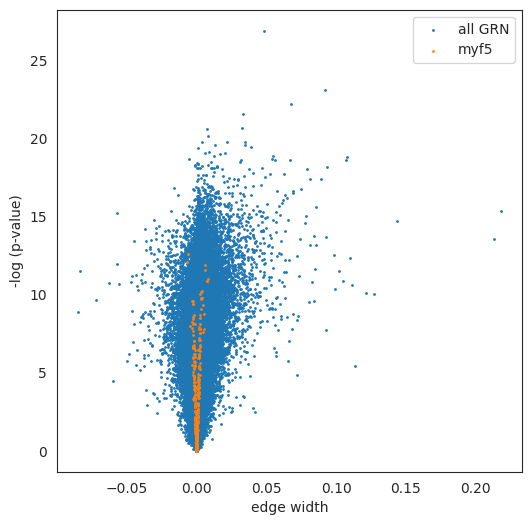

In [177]:
# Check the volcano plot for GRN "filtering" process
Links_15somites.links_dict["PSM"]

plt.scatter(Links_15somites.links_dict["PSM"].coef_mean, Links_15somites.links_dict["PSM"]["-logp"], s=1)
plt.scatter(df.coef_mean, df["-logp"],s=1)
plt.legend(["all GRN", "myf5"])
plt.xlabel("edge width")
plt.ylabel("-log (p-value)")

## NOTES:

- So, it's not as exciting as we hoped. There are genes whose cis-regulatory elements (CCANs) change over time, but they don't contribute that much to our GRN. (very 

In [ ]:
# Let's check out the "unfiltered" GRN
celltype = "PSM"
gene_name = "myf5"
df = Links_15somites.links_dict[celltype][Links_15somites.links_dict[celltype].target==gene_name]
df

# Now, let's check if some of the "source" (regulatory TFs) are from the "unique" cis-regulatory elements
list_unique_TFs_PSM_myf5 = []

for TF in df.source:
    if TF in unique_regTFs_15_20:
        list_unique_TFs_PSM_myf5.append(TF)
    else:
        pass
list_unique_TFs_PSM_myf5

In [166]:
df_PSM_15somites = Links_15somites.filtered_links["PSM"]
df_PSM_15somites

# gene name
gene_name = "myf5"

print(df_PSM_15somites[df_PSM_15somites.source==gene_name])

print(df_PSM_15somites[df_PSM_15somites.target==gene_name])

,source,target,coef_mean,coef_abs,p,-logp
124022,creb5b,myf5,0.001003,0.001003,1.116021e-04,3.952328
124023,mef2b,myf5,-0.000777,0.000777,1.324784e-02,1.877855
124024,bcl11ab,myf5,-0.000137,0.000137,6.987439e-01,0.155682
124025,foxp1b,myf5,-0.000351,0.000351,1.584702e-01,0.800052
124026,nkx6.1,myf5,-0.001329,0.001329,4.755597e-04,3.322795
...,...,...,...,...,...,...
124294,hoxc3a,myf5,0.001126,0.001126,2.012847e-04,3.696189
124295,nr2e1,myf5,0.002398,0.002398,7.563481e-09,8.121278
124296,pnx,myf5,-0.001315,0.001315,7.669920e-09,8.115209
124297,fli1b,myf5,0.000744,0.000744,8.751983e-04,3.057894


In [147]:
df_subset = df_PSM_15somites[df_PSM_15somites.source==gene_name]
df_subset

,source,target,coef_mean,coef_abs,p,-logp
9053,myf5,apoc1,0.037023,0.037023,1.079233e-10,9.966885
167056,myf5,rps20,0.035168,0.035168,4.063624e-10,9.391087
158051,myf5,qkia,0.035125,0.035125,2.101988e-14,13.677370
53287,myf5,efnb2b,0.030132,0.030132,2.817400e-12,11.550152
138592,myf5,nucks1a,0.023397,0.023397,2.206118e-14,13.656371
159869,myf5,raraa,0.023349,0.023349,3.642034e-12,11.438656
121971,myf5,msgn1,0.023245,0.023245,4.683377e-13,12.329441
115507,myf5,mef2d,0.023047,0.023047,1.175753e-05,4.929684
78757,myf5,h3f3d,0.020149,0.020149,7.275081e-13,12.138162
207817,myf5,tmsb4x,0.020031,0.020031,9.227631e-07,6.034910


In [236]:
Links_20somites.filtered_links["PSM"]

,source,target,coef_mean,coef_abs,p,-logp
24535,egr2b,cirbpa,0.146845,0.146845,6.719124e-18,17.172687
24514,klf6a,cirbpa,0.120001,0.120001,3.198143e-13,12.495102
24539,klf17,cirbpa,0.112417,0.112417,1.538172e-14,13.812995
139668,creb5b,slit3,0.110357,0.110357,1.018092e-10,9.992213
66349,rxraa,hmgb2a,-0.105660,0.105660,9.311670e-15,14.030972
...,...,...,...,...,...,...
53822,meox1,foxp4,-0.012382,0.012382,3.227934e-13,12.491075
107889,nr2f1b,pax6a,0.012381,0.012381,3.821035e-10,9.417819
85166,lhx2b,marcksl1b,-0.012381,0.012381,7.051622e-07,6.151711
159228,en2b,tuba1a,0.012375,0.012375,1.489846e-08,7.826859


In [233]:
1

1